In [1]:
# -*- coding: utf-8 -*-

import time
import heapq
import numpy as np
from scipy import optimize
from scipy.optimize import fsolve
from concurrent.futures import ProcessPoolExecutor, as_completed
import matplotlib.pyplot as plt
import os
import pandas as pd
import geopandas as gpd 

inputLocation = "Taipei/"
CPU_COUNT = os.cpu_count() or 1
print(f"偵測到電腦核心數 = {CPU_COUNT}")

# -------------------------------
# 基本資料結構與初始化
# -------------------------------
class Zone:
    def __init__(self, _tmpIn):
        self.zoneId = _tmpIn[0]
        self.lat = 0
        self.lon = 0
        self.destList = []

class Node:
    '''
    此類別儲存網絡中節點的資訊
    '''
    def __init__(self, _tmpIn):
        self.Id = _tmpIn[0]
        self.lat = 0
        self.lon = 0
        self.outLinks = []
        self.inLinks = []
        self.label = float("inf")
        self.pred = ""
        self.inDegree = 0
        self.outDegree = 0
        self.order = 0  # 拓樸排序順序
        self.wi = 0.0   # Dial 演算法中節點權重
        self.xi = 0.0   # Dial 演算法中節點流量
        self.xj = 0.0   # 用於流量回溯時累計需求

class Link:
    '''
    此類別儲存網絡中連結的資訊
    flowCar 與 flowScooter 用來分別儲存汽車與機車的流量
    '''
    def __init__(self, _tmpIn):
        self.tailNode = _tmpIn[0]
        self.headNode = _tmpIn[1]
        self.capacity = float(_tmpIn[2])  # veh per hour
        self.length = float(_tmpIn[3])   # Length
        self.fft = float(_tmpIn[4])      # Free flow travel time (min)
        self.beta = float(_tmpIn[6])
        self.alpha = float(_tmpIn[5])
        self.speedLimit = float(_tmpIn[7])
        if len(_tmpIn) > 9:
            self.NMoto = int(_tmpIn[9])
            self.NCar = int(_tmpIn[10])
        else:
            self.NMoto = 0
            self.NCar = 0
            print(f'警告：連結 {_tmpIn[0]} -> {_tmpIn[1]} 沒有機車或汽車禁行資訊，預設為 0')

        self.flowCar = 0.0
        self.flowScooter = 0.0
        self.cost = float(_tmpIn[4])
        self.logLike = 0.0
        self.reasonable = True
        self.wij = 0.0
        self.xij = 0.0

class Demand:
    '''
    讀取需求時，額外儲存 vehType (1=汽車, 2=機車)
    '''
    def __init__(self, _tmpIn):
        self.fromZone = _tmpIn[0]
        self.toNode = _tmpIn[1]
        self.demand = float(_tmpIn[2])
        self.vehType = _tmpIn[3]  # '1' or '2'

def readDemand():
    '''
    讀取需求檔案，需求檔結構假設:
    fromZone  toZone  demand  vehType
    其中 vehType = '1' (汽車) or '2' (機車)
    '''
    inFile = open(inputLocation + f"{year}{rush_hour}{case}_demand.dat", encoding="utf-8") #f"{year}{rush_hour}_demand.dat"
    _ = inFile.readline().strip().split("\t")  # 讀掉標頭
    for x in inFile:
        tmpIn = x.strip().split("\t")
        demandObj = Demand(tmpIn)
        tripSet[(tmpIn[0], tmpIn[1], tmpIn[3])] = demandObj

        if tmpIn[0] not in zoneSet:
            zoneSet[tmpIn[0]] = Zone([tmpIn[0]])
        if tmpIn[1] not in zoneSet:
            zoneSet[tmpIn[1]] = Zone([tmpIn[1]])
        if tmpIn[1] not in zoneSet[tmpIn[0]].destList:
            zoneSet[tmpIn[0]].destList.append(tmpIn[1])

        originZones.add((tmpIn[0], tmpIn[3]))

    inFile.close()
    print(len(tripSet), "OD pairs (含車種)")
    print(len(zoneSet), "zones")

def readNetwork():
    inFile = open(inputLocation + f"Net_modified_{scenario}_{rush_hour}調撥.dat", encoding="utf-8")
    tmpIn = inFile.readline().strip().split("\t")  # 讀掉標頭
    for x in inFile:
        tmpIn = x.strip().split("\t")
        linkSet[(tmpIn[0], tmpIn[1])] = Link(tmpIn)
        if tmpIn[0] not in nodeSet:
            nodeSet[tmpIn[0]] = Node([tmpIn[0]])
        if tmpIn[1] not in nodeSet:
            nodeSet[tmpIn[1]] = Node([tmpIn[1]])
        if tmpIn[1] not in nodeSet[tmpIn[0]].outLinks:
            nodeSet[tmpIn[0]].outLinks.append(tmpIn[1])
        if tmpIn[0] not in nodeSet[tmpIn[1]].inLinks:
            nodeSet[tmpIn[1]].inLinks.append(tmpIn[0])
    inFile.close()
    print(len(nodeSet), "nodes")
    print(len(linkSet), "links")

def readTurnRestrictions(filename="turn_restrict.dat"):
    '''
    turn_restrict.dat 假設五欄: A B C set pen
    pen = -1 -> 禁止通行
    pen = 2  -> 機車兩段式左轉 +1分鐘
    pen = 3  -> 機車兩段式左轉(大型路口) +2分鐘
    '''
    
    global turn_restrict
    try:
        with open(inputLocation + filename) as inFile:
            for line in inFile:
                parts = line.strip().split()
                if len(parts) == 5:
                    A, B, C, vehSet, pen = parts
                    turn_restrict[(A, B, C, vehSet)] = pen
        print(f"成功讀取 {len(turn_restrict)} 筆轉向限制/懲罰資料")
    except FileNotFoundError:
        print(f"警告：未找到禁止轉向檔案 {filename}，將不施加任何限制。")

def DijkstraHeap(origin, vehType):
    '''
    多車種 Dijkstra，若遇到禁行機車 (NMoto=1) 會跳過
    '''
    for n in nodeSet:
        nodeSet[n].label = float("inf")
        nodeSet[n].pred = ""
    nodeSet[origin].label = 0.0
    nodeSet[origin].pred = "NA"
    SE = [(0, origin)]
    while SE:
        currentNode = heapq.heappop(SE)[1]
        currentLabel = nodeSet[currentNode].label
        prevNode = nodeSet[currentNode].pred
        for toNode in nodeSet[currentNode].outLinks:
            addPenalty = 0.0
            if vehType == '2' and linkSet[(currentNode, toNode)].NMoto == 1:
                continue
            if vehType == '1' and linkSet[(currentNode, toNode)].NCar == 1:
                continue
            if prevNode and prevNode != "NA":
                trKey = (prevNode, currentNode, toNode, vehType)
                if trKey in turn_restrict:
                    penVal = turn_restrict[trKey]
                    if penVal == '-1':
                        continue
                    else:
                        if vehType == '2':
                            if penVal == '2':
                                addPenalty = 2.0
                            elif penVal == '3':
                                addPenalty = 3.0

            link = (currentNode, toNode)
            newLabel = currentLabel + linkSet[link].cost + addPenalty
            existingLabel = nodeSet[toNode].label
            if newLabel < existingLabel:
                nodeSet[toNode].label = newLabel
                nodeSet[toNode].pred = currentNode
                heapq.heappush(SE, (newLabel, toNode))

def tracePreds(dest):
    '''
    回溯最短路徑，若偵測到 pred 為空或 (prevNode, dest) 不在 linkSet 中就提早停止
    '''
    spLinks = []
    visited = set()
    while True:
        prevNode = nodeSet[dest].pred
        if prevNode == "NA":
            break
        if dest in visited:
            print(f"循環偵測：節點 {dest} 無法正確回溯")
            break
        visited.add(dest)
        if (not prevNode) or ((prevNode, dest) not in linkSet):
            print(f"警告：節點 {dest} 的 pred={prevNode} 不存在對應 link，停止回溯。")
            break
        spLinks.append((prevNode, dest))
        dest = prevNode
    return spLinks

def updateTravelTime():
    '''
    使用 BPR formula 更新 travel time
    '''
    for l in linkSet:
        totalFlow = linkSet[l].flowCar + linkSet[l].flowScooter
        ratio = totalFlow / linkSet[l].capacity if linkSet[l].capacity != 0 else 0
        linkSet[l].cost = linkSet[l].fft * (1 + linkSet[l].alpha * (ratio ** linkSet[l].beta))

def findAlpha(x_bar_car, x_bar_scooter, iteration=1):
    '''
    混合策略：處理 Bisection 邊界情況，並整合 fsolve。
    '''
    def df(alpha):
        sum_derivative = 0
        # 為了效能，將 linkSet.keys() 提出循環
        link_keys = linkSet.keys()
        for l in link_keys:
            tmpFlowCar = linkSet[l].flowCar + alpha * (x_bar_car[l] - linkSet[l].flowCar)
            tmpFlowScooter = linkSet[l].flowScooter + alpha * (x_bar_scooter[l] - linkSet[l].flowScooter)
            totalFlow = tmpFlowCar + tmpFlowScooter
            if linkSet[l].capacity > 0:
                tmpCost = linkSet[l].fft * (1 + linkSet[l].alpha * ((totalFlow / linkSet[l].capacity) ** linkSet[l].beta))
            else:
                tmpCost = linkSet[l].fft # 容量為0時，成本等於自由流時間
            sum_derivative += ((x_bar_car[l] - linkSet[l].flowCar) + (x_bar_scooter[l] - linkSet[l].flowScooter)) * tmpCost
        return sum_derivative

    # 策略1: 嘗試 fsolve (最快)
    try:
        sol, infodict, ier, mesg = fsolve(df, 0.2, full_output=True)
        if ier == 1 and 0.001 < sol[0] < 0.999:
            if abs(df(sol[0])) < 1e-4: # 放寬一點容忍度
                print(f"迭代 {iteration}: fsolve 成功找到步長 α={sol[0]:.4f}")
                return sol[0]
    except Exception:
        pass

    # 策略2: 嘗試 bisection (穩定)
    try:
        sol = optimize.bisect(df, 0, 1, xtol=1e-3)
        if 0.001 < sol < 0.999:
            print(f"迭代 {iteration}: Bisection 找到步長 α={sol:.4f}")
            return sol
    except ValueError:
        # Bisection 失敗，因為 f(0) 和 f(1) 同號
        # 檢查 df(1) 的符號
        if df(1) < 0:
            # 如果在 alpha=1 處導數仍為負，表示目標函數在 [0,1] 上單調遞減
            # 最佳步長就是 1
            print(f"迭代 {iteration}: Bisection 失敗 (邊界同號)，導數在 α=1 仍為負，取 α=1.0")
            return 1.0
        else:
            # 極少見情況，可能 df(0) 和 df(1) 都為正
            print(f"迭代 {iteration}: Bisection 失敗，使用黃金比例法")
            return golden_section_search(df, 0, 1)

    # 策略3: 最終的 fallback
    print(f"迭代 {iteration}: 所有方法失敗，使用預設步長 0.1")
    return 0.1

def golden_section_search(func, a, b, tol=1e-4, max_iter=20):
    '''
    黃金比例搜尋法找最佳步長，針對交通指派優化
    使用較寬鬆的容忍度和最大迭代次數限制，避免過度優化
    '''
    phi = (1 + 5**0.5) / 2  # 黃金比例
    resphi = 2 - phi
    
    x1 = a + resphi * (b - a)
    x2 = b - resphi * (b - a)
    f1 = abs(func(x1))
    f2 = abs(func(x2))
    
    iteration = 0
    while abs(b - a) > tol and iteration < max_iter:
        if f1 < f2:
            b = x2
            x2 = x1
            f2 = f1
            x1 = a + resphi * (b - a)
            f1 = abs(func(x1))
        else:
            a = x1
            x1 = x2
            f1 = f2
            x2 = b - resphi * (b - a)
            f2 = abs(func(x2))
        iteration += 1
    
    result = (a + b) / 2
    return max(0.05, min(0.95, result))  # 確保結果在合理範圍內

def loadAON():
    '''
    多車種 All-or-Nothing: 針對每組 (originZone, vehType) 做最短路徑
    回傳:
        totalSPTT (Car + Scooter)
        x_bar_car
        x_bar_scooter
    '''
    x_bar_car = {l: 0.0 for l in linkSet}
    x_bar_scooter = {l: 0.0 for l in linkSet}
    totalSPTT = 0.0

    for (origin, vt) in originZones:
        DijkstraHeap(origin, vt)
        for s in zoneSet[origin].destList:
            if (not np.isfinite(nodeSet[s].label)) or nodeSet[s].label < 0:
                continue
            if (origin, s, vt) in tripSet:
                dem = tripSet[(origin, s, vt)].demand
            else:
                dem = 0.0
            totalSPTT += nodeSet[s].label * dem
            if origin != s:
                for spLink in tracePreds(s):
                    if vt == '1':
                        x_bar_car[spLink] += dem
                    else:
                        x_bar_scooter[spLink] += dem

    return totalSPTT, x_bar_car, x_bar_scooter

def writeUEresults():
    outFile = open(f"{year}_{scenario}_{rush_hour}{case}_UE_results.dat", "w", encoding="utf-8")
    tmpOut = "tailNode\theadNode\tcapacity\tlength\tfft\tUE_travelTime\tUE_flow"
    outFile.write(tmpOut + "\n")
    for i in linkSet:
        tmpOut = f"{linkSet[i].tailNode}\t{linkSet[i].headNode}\t{linkSet[i].capacity}\t{linkSet[i].length}\t{linkSet[i].fft}\t{linkSet[i].cost}\t{linkSet[i].flowCar + linkSet[i].flowScooter}"
        outFile.write(tmpOut + "\n")
    outFile.close()

def assignment(loading, algorithm, accuracy, maxIter, allow, recal, parallel_loading=False):
    '''
    執行多車種交通指派時，若判定到 TSTT 或 SPTT 為 0 或非數值，就跳過避免 gap 計算出 NaN。
    修正了初始化流程，確保 FW 演算法有正確的起點。
    '''
    startP = time.time()
    
    # ---- 初始化 ----
    for l in linkSet:
        linkSet[l].flowCar = 0.0
        linkSet[l].flowScooter = 0.0
    updateTravelTime() # 確保成本為自由流時間

    # ---- FW 演算法步驟 0: 執行初始 AON ----
    print("==== 執行初始 AON 載入 ====")
    SPTT, x_bar_car, x_bar_scooter = loadAON()
    for l in linkSet:
        linkSet[l].flowCar = x_bar_car[l]
        linkSet[l].flowScooter = x_bar_scooter[l]
    
    updateTravelTime() # 基於 AON 流量更新成本

    # ---- 初始化迭代變數 ----
    it = 1
    count = 0
    current_min_gap = float("inf")
    gap = float("inf")
    gap_lst = []
    tstt_lst = []
    sptt_lst = []
    alpha_lst = []

    print("==== 開始多車種交通指派迭代 ====")
    while it <= maxIter:
        # ---- FW 演算法步驟 1: 尋找下降方向 (AON) ----
        SPTT, x_bar_car, x_bar_scooter = loadAON()
        
        # ---- 計算 TSTT 和 Gap ----
        TSTT = 0.0
        for a in linkSet:
            flow_sum = linkSet[a].flowCar + linkSet[a].flowScooter
            if not np.isfinite(linkSet[a].cost) or linkSet[a].cost < 0 or flow_sum < 0:
                continue
            TSTT += linkSet[a].cost * flow_sum

        tstt_lst.append(TSTT)
        sptt_lst.append(SPTT)

        if (not np.isfinite(SPTT)) or (SPTT <= 1e-6): # 避免除以零
            print("警告：SPTT 為 0 或非數值，將 gap 設為 0 並中止迭代。")
            gap = 0
        else:
            gap_val = (TSTT / SPTT) - 1
            gap = round(abs(gap_val), 5) if np.isfinite(gap_val) else float("inf")

        gap_lst.append(gap)

        # ---- 檢查收斂條件 ----
        if gap <= accuracy:
            print(f"收斂達成於第 {it} 次迭代，Gap: {gap}")
            break

        if gap < current_min_gap and np.isfinite(gap):
            current_min_gap = gap
            count = 0
            writeUEresults()
            print(f"Iteration {it} improved gap: {gap}, TSTT: {TSTT:.2f} min, SPTT: {SPTT:.2f} min, count reset to 0")
        else:
            count += 1
            print(f"Iteration {it} no improvement in gap: {gap}, TSTT: {TSTT:.2f} min, SPTT: {SPTT:.2f} min, count: {count}")
            if count > allow:
                print("The assignment did not converge: no improvement in", allow, "iterations, current gap:", gap)
                break
        
        # ---- FW 演算法步驟 2: 線性搜尋找步長 ----
        if algorithm == "MSA":
            alpha = 1.0 / (it + 1) # MSA 的標準更新
        elif algorithm == "FW":
            alpha = findAlpha(x_bar_car, x_bar_scooter, it)
        else:
            print("Terminating the program.....不明演算法:", algorithm)
            return None
        
        alpha_lst.append(alpha)
        print(f"    alpha: {alpha:.4f}")

        # ---- FW 演算法步驟 3: 更新流量和成本 ----
        for l in linkSet:
            linkSet[l].flowCar     = (1 - alpha) * linkSet[l].flowCar     + alpha * x_bar_car[l]
            linkSet[l].flowScooter = (1 - alpha) * linkSet[l].flowScooter + alpha * x_bar_scooter[l]
        
        updateTravelTime()

        print(f"    Iteration {it} completed :)")
        it += 1

    if it > maxIter:
        print("The assignment did not converge: max iterations reached, current gap:", gap)

    # ---- 計算最終結果 ----
    final_TSTT = TSTT
    final_SPTT = SPTT
    total_flow_car = sum(l.flowCar for l in linkSet.values())
    total_flow_scooter = sum(l.flowScooter for l in linkSet.values())

    print("\n==== 最終結果 ====")
    print(f"總體旅行時間 (TSTT): {final_TSTT:.2f} 分鐘")
    print(f"最短路徑旅行時間 (SPTT): {final_SPTT:.2f} 分鐘")
    print(f"總汽車流量: {total_flow_car:.2f} 輛/小時")
    print(f"總機車流量: {total_flow_scooter:.2f} 輛/小時")
    print(f"總車流量: {total_flow_car + total_flow_scooter:.2f} 輛/小時")
    print(f"平均旅行時間: {final_TSTT / (total_flow_car + total_flow_scooter):.2f} 分鐘/輛" if (total_flow_car + total_flow_scooter) > 0 else "無法計算平均旅行時間")
    print(f"最終 Gap: {gap:.5f}")
    print(f"平均步長: {np.mean(alpha_lst):.4f}, 步長標準差: {np.std(alpha_lst):.4f}")
    
    print("Assignment took", time.time() - startP, "seconds")
    print("Assignment stopped in", it, "iterations, current gap:", gap)
    min_gap = min(gap_lst) if gap_lst else float("inf")
    min_gap_it = gap_lst.index(min_gap) + 1 if gap_lst else 0
    print("Minimum gap found at iteration", min_gap_it, "with gap", min_gap)

    if not recal:
        # 繪製收斂圖
        fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 10))
        
        # Gap 收斂圖
        ax1.plot(range(1, len(gap_lst) + 1), gap_lst, marker='o')
        ax1.set_xlabel("Iteration")
        ax1.set_ylabel("Gap")
        ax1.set_title("Multi-Class Gap vs. Iteration")
        ax1.grid()
        
        # TSTT 收斂圖
        ax2.plot(range(1, len(tstt_lst) + 1), tstt_lst, marker='s', color='red')
        ax2.set_xlabel("Iteration")
        ax2.set_ylabel("TSTT (minutes)")
        ax2.set_title("Total System Travel Time vs. Iteration")
        ax2.grid()
        
        # 步長變化圖
        ax3.plot(range(1, len(alpha_lst) + 1), alpha_lst, marker='^', color='green')
        ax3.axhline(y=0.2, color='orange', linestyle='--', label='Fallback (0.2)')
        ax3.set_xlabel("Iteration")
        ax3.set_ylabel("Step Size (Alpha)")
        ax3.set_title("Step Size vs. Iteration")
        ax3.legend()
        ax3.grid()
        
        plt.tight_layout()
        plt.savefig(f"{year}_{scenario}_{rush_hour}_convergence.png")
        plt.show()

    # 回傳結果供後續使用
    return {
        'TSTT': final_TSTT,
        'SPTT': final_SPTT,
        'total_flow_car': total_flow_car,
        'total_flow_scooter': total_flow_scooter,
        'gap': gap,
        'iterations': it,
        'alpha_stats': {
            'mean': np.mean(alpha_lst),
            'std': np.std(alpha_lst),
            'values': alpha_lst
        }
    }

def checkNetworkHealth():
    print("==== Network Health Check ====")
    isolated = [n for n in nodeSet if len(nodeSet[n].inLinks) == 0 and len(nodeSet[n].outLinks) == 0]
    print(f"完全孤立節點: {len(isolated)}")
    unreachable = [node for node in nodeSet if nodeSet[node].pred == ""]
    print(f"目前未標定 predecessor 的節點數: {len(unreachable)}")
    allFlowZero = all((linkSet[l].flowCar + linkSet[l].flowScooter) == 0.0 for l in linkSet)
    print("所有流量皆為 0？", allFlowZero)

def savetoShapefile():
    cap_dict = {}
    with open('TRTS4S_Capacity.csv', 'r') as f:
        lines = f.readlines()
        for line in lines[1:]:
            parts = line.strip().split(',')
            class_num = int(parts[0])
            for i in range(1, len(parts)):
                lanes = i
                capacity = int(parts[i])
                cap_dict[(class_num, lanes)] = capacity
    ue_results = pd.read_csv(f"{year}_{scenario}_{rush_hour}{case}_UE_results.dat", sep="\t")
    gdf = gpd.read_file(f"Network/Net_modified_{scenario}_{rush_hour}調撥.shp")
    ue_results.rename(columns={"tailNode": "A", "headNode": "B"}, inplace=True)
    gdf = gdf.merge(ue_results[["A", "B", "capacity", "UE_travelTime", "UE_flow"]], on=["A", "B"], how="left")
    gdf['capacity'] = gdf.apply(lambda row: get_capacity(row, cap_dict), axis=1)
    gdf["V/C"] = gdf["UE_flow"] / gdf["capacity"]
    gdf["assigned_speed"] = gdf["LENGTH"] / gdf["UE_travelTime"] * 60 
    gdf.to_file(f"{year}_{scenario}_{rush_hour}{case}_UE_results.shp")

def get_capacity(row, cap_dict):
    class_num = row['CLASS_110']
    lanes = row['LANES_110']
    if (class_num, lanes) in cap_dict:
        return cap_dict[(class_num, lanes)]
    else:
        print(f"Warning: No capacity found for class {class_num} and lanes {lanes}. Using default value 0.")
        return 0

偵測到電腦核心數 = 6


1045458 OD pairs (含車種)
723 zones
10154 nodes
25664 links
成功讀取 1756 筆轉向限制/懲罰資料
Reading the network data took 6.72 secs
==== 執行初始 AON 載入 ====
==== 開始多車種交通指派迭代 ====
Iteration 1 improved gap: 6.51521, TSTT: 181245562.58 min, SPTT: 24117150.61 min, count reset to 0
迭代 1: fsolve 成功找到步長 α=0.2447
    alpha: 0.2447
    Iteration 1 completed :)
Iteration 2 improved gap: 2.05309, TSTT: 76915519.73 min, SPTT: 25192699.20 min, count reset to 0
迭代 2: fsolve 成功找到步長 α=0.2683
    alpha: 0.2683
    Iteration 2 completed :)
Iteration 3 improved gap: 0.63452, TSTT: 41783552.19 min, SPTT: 25563221.54 min, count reset to 0
迭代 3: fsolve 成功找到步長 α=0.2155
    alpha: 0.2155
    Iteration 3 completed :)
Iteration 4 improved gap: 0.27622, TSTT: 32633256.51 min, SPTT: 25570304.26 min, count reset to 0
迭代 4: fsolve 成功找到步長 α=0.1548
    alpha: 0.1548
    Iteration 4 completed :)
Iteration 5 improved gap: 0.15345, TSTT: 29865636.13 min, SPTT: 25892533.47 min, count reset to 0
迭代 5: fsolve 成功找到步長 α=0.1709
    alpha: 0.1

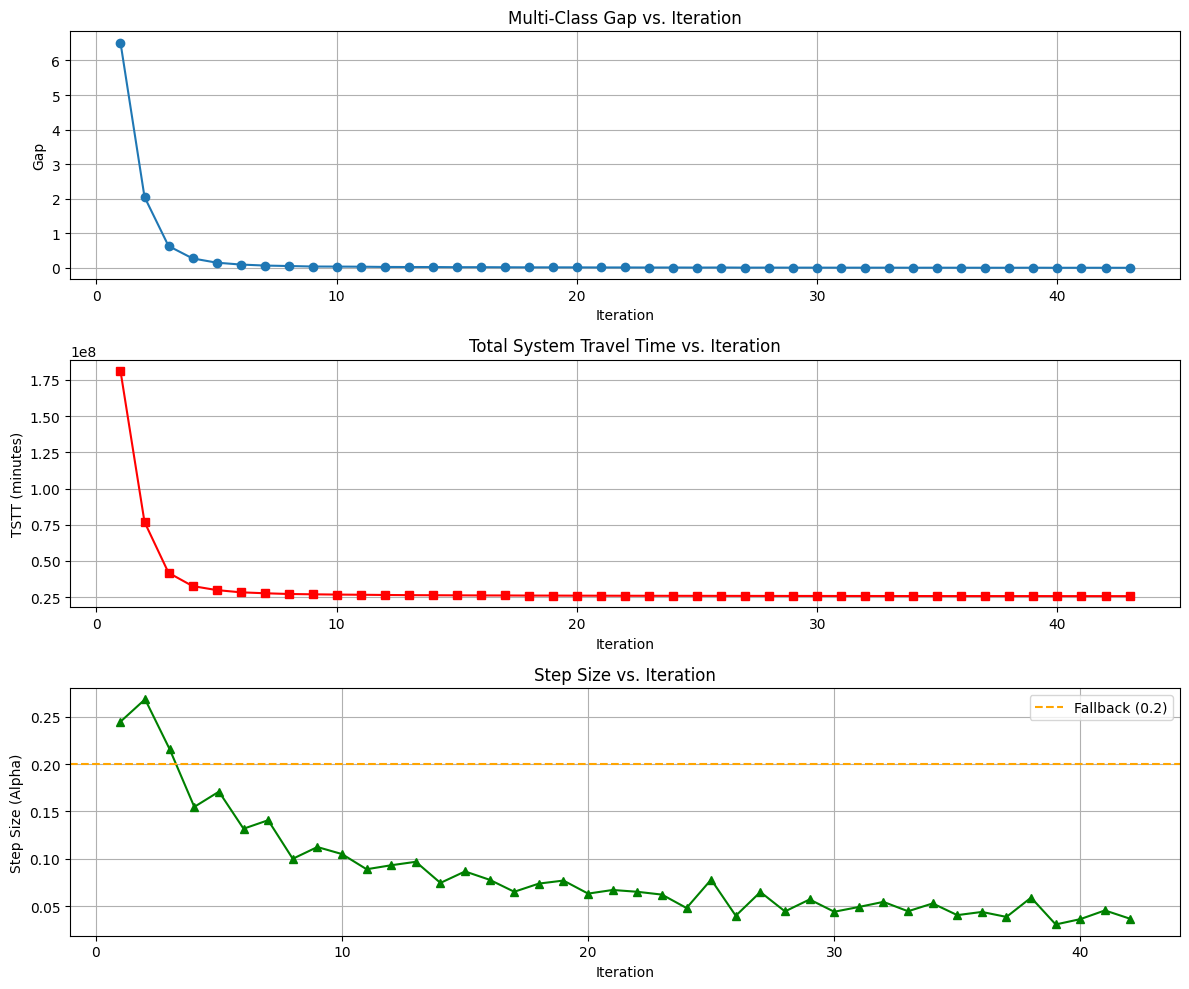

==== Network Health Check ====
完全孤立節點: 0
目前未標定 predecessor 的節點數: 1146
所有流量皆為 0？ False


C:\Users\chiuj\AppData\Local\Temp\ipykernel_19612\1809701336.py:540: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf.to_file(f"{year}_{scenario}_{rush_hour}{case}_UE_results.shp")
C:\Users\chiuj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyogrio\geopandas.py:662: UserWarning: 'crs' was not provided.  The output dataset will not have projection information defined and may not be usable in other systems.
  write(
C:\Users\chiuj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'UE_travelTime' to 'UE_travelT'
  ogr_write(
C:\Users\chiuj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/launder

1045458 OD pairs (含車種)
723 zones
10154 nodes
25663 links
成功讀取 1756 筆轉向限制/懲罰資料
Reading the network data took 6.89 secs
==== 執行初始 AON 載入 ====
==== 開始多車種交通指派迭代 ====
Iteration 1 improved gap: 3.34753, TSTT: 97612224.74 min, SPTT: 22452360.73 min, count reset to 0
迭代 1: fsolve 成功找到步長 α=0.3287
    alpha: 0.3287
    Iteration 1 completed :)
Iteration 2 improved gap: 0.67984, TSTT: 38454110.65 min, SPTT: 22891470.34 min, count reset to 0
迭代 2: fsolve 成功找到步長 α=0.2858
    alpha: 0.2858
    Iteration 2 completed :)
Iteration 3 improved gap: 0.21758, TSTT: 27755396.66 min, SPTT: 22795467.26 min, count reset to 0
迭代 3: fsolve 成功找到步長 α=0.2298
    alpha: 0.2298
    Iteration 3 completed :)
Iteration 4 improved gap: 0.10545, TSTT: 25259809.99 min, SPTT: 22850282.58 min, count reset to 0
迭代 4: fsolve 成功找到步長 α=0.1731
    alpha: 0.1731
    Iteration 4 completed :)
Iteration 5 improved gap: 0.05966, TSTT: 24311830.82 min, SPTT: 22943007.46 min, count reset to 0
迭代 5: fsolve 成功找到步長 α=0.1833
    alpha: 0.18

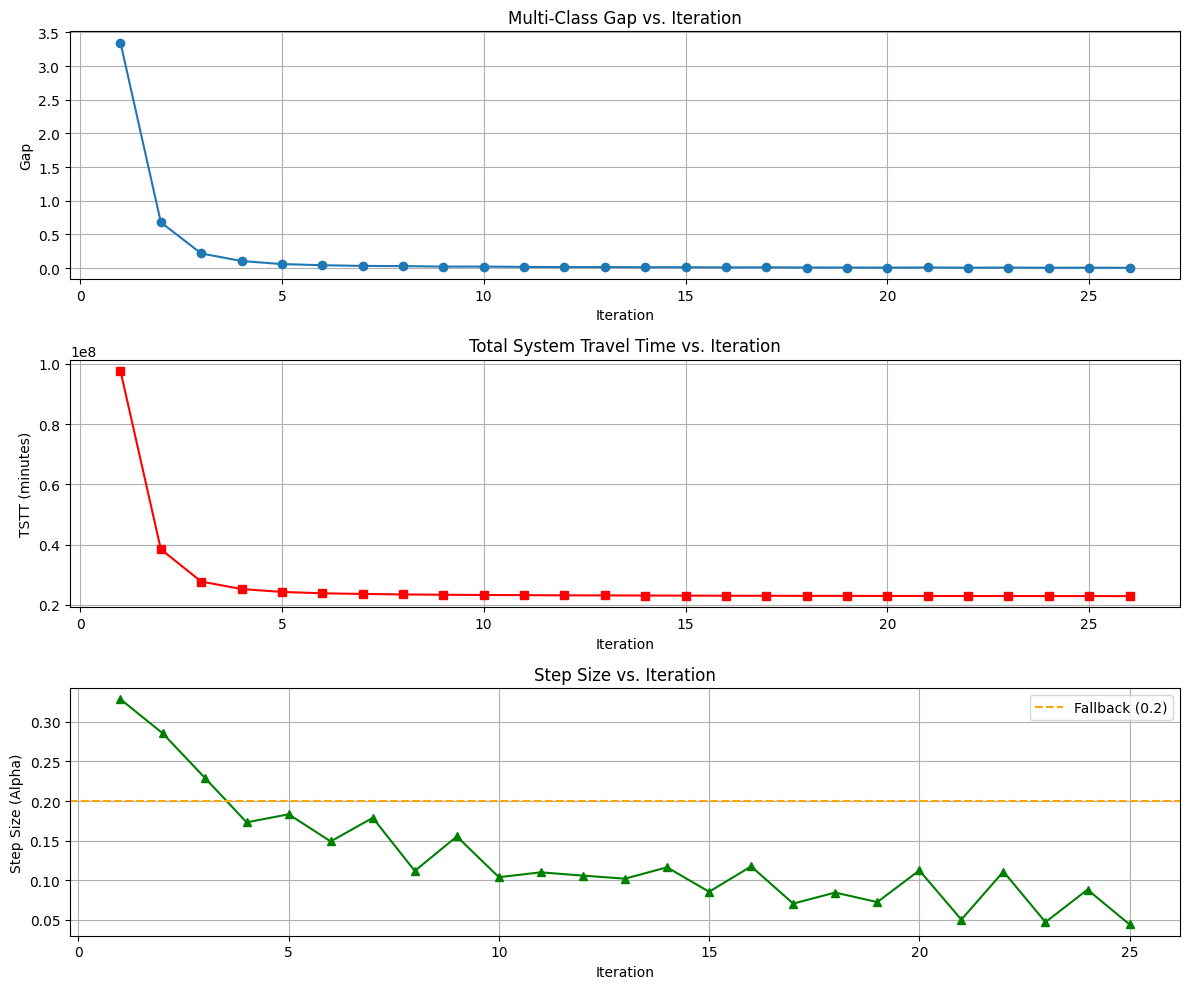

==== Network Health Check ====
完全孤立節點: 0
目前未標定 predecessor 的節點數: 1146
所有流量皆為 0？ False


C:\Users\chiuj\AppData\Local\Temp\ipykernel_19612\1809701336.py:540: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf.to_file(f"{year}_{scenario}_{rush_hour}{case}_UE_results.shp")
C:\Users\chiuj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyogrio\geopandas.py:662: UserWarning: 'crs' was not provided.  The output dataset will not have projection information defined and may not be usable in other systems.
  write(
C:\Users\chiuj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'UE_travelTime' to 'UE_travelT'
  ogr_write(
C:\Users\chiuj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/launder

1045458 OD pairs (含車種)
723 zones
10154 nodes
25664 links
成功讀取 1756 筆轉向限制/懲罰資料
Reading the network data took 5.57 secs
==== 執行初始 AON 載入 ====
==== 開始多車種交通指派迭代 ====
Iteration 1 improved gap: 6.63353, TSTT: 184225699.28 min, SPTT: 24133734.87 min, count reset to 0
迭代 1: fsolve 成功找到步長 α=0.2437
    alpha: 0.2437
    Iteration 1 completed :)
Iteration 2 improved gap: 2.10028, TSTT: 78307377.42 min, SPTT: 25258184.06 min, count reset to 0
迭代 2: fsolve 成功找到步長 α=0.2640
    alpha: 0.2640
    Iteration 2 completed :)
Iteration 3 improved gap: 0.66037, TSTT: 42641354.46 min, SPTT: 25681860.88 min, count reset to 0
迭代 3: fsolve 成功找到步長 α=0.2120
    alpha: 0.2120
    Iteration 3 completed :)
Iteration 4 improved gap: 0.29006, TSTT: 33195360.57 min, SPTT: 25731559.79 min, count reset to 0
迭代 4: fsolve 成功找到步長 α=0.1633
    alpha: 0.1633
    Iteration 4 completed :)
Iteration 5 improved gap: 0.15782, TSTT: 30114490.50 min, SPTT: 26009623.42 min, count reset to 0
迭代 5: fsolve 成功找到步長 α=0.1613
    alpha: 0.1

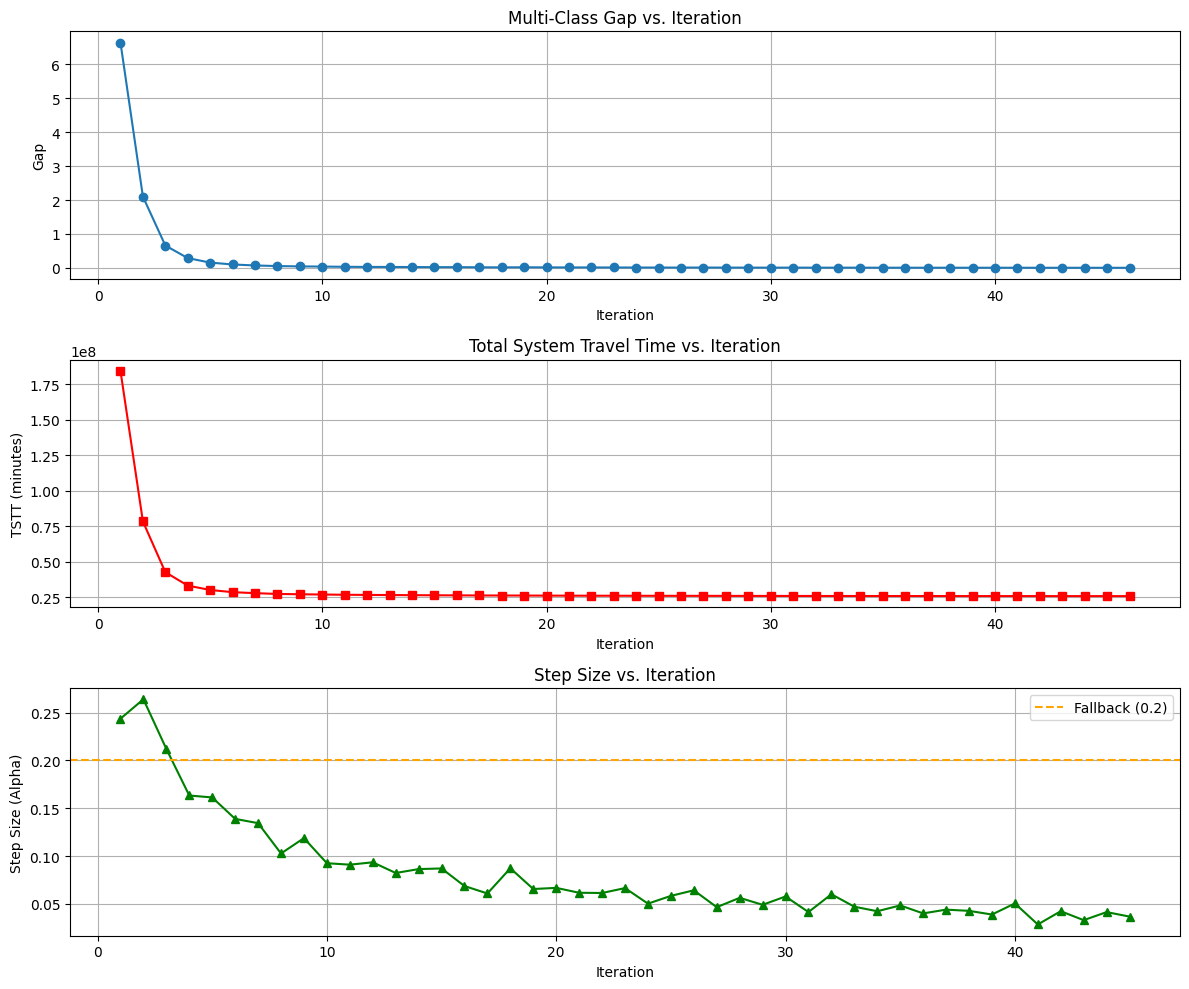

==== Network Health Check ====
完全孤立節點: 0
目前未標定 predecessor 的節點數: 1146
所有流量皆為 0？ False


C:\Users\chiuj\AppData\Local\Temp\ipykernel_19612\1809701336.py:540: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf.to_file(f"{year}_{scenario}_{rush_hour}{case}_UE_results.shp")
C:\Users\chiuj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyogrio\geopandas.py:662: UserWarning: 'crs' was not provided.  The output dataset will not have projection information defined and may not be usable in other systems.
  write(
C:\Users\chiuj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'UE_travelTime' to 'UE_travelT'
  ogr_write(
C:\Users\chiuj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/launder

1045458 OD pairs (含車種)
723 zones
10154 nodes
25663 links
成功讀取 1756 筆轉向限制/懲罰資料
Reading the network data took 5.81 secs
==== 執行初始 AON 載入 ====
==== 開始多車種交通指派迭代 ====
Iteration 1 improved gap: 3.75147, TSTT: 106982618.47 min, SPTT: 22515709.35 min, count reset to 0
迭代 1: fsolve 成功找到步長 α=0.3211
    alpha: 0.3211
    Iteration 1 completed :)
Iteration 2 improved gap: 0.79797, TSTT: 41339658.96 min, SPTT: 22992442.29 min, count reset to 0
迭代 2: fsolve 成功找到步長 α=0.2930
    alpha: 0.2930
    Iteration 2 completed :)
Iteration 3 improved gap: 0.24412, TSTT: 28460715.07 min, SPTT: 22876220.91 min, count reset to 0
迭代 3: fsolve 成功找到步長 α=0.2255
    alpha: 0.2255
    Iteration 3 completed :)
Iteration 4 improved gap: 0.11646, TSTT: 25634742.26 min, SPTT: 22960768.60 min, count reset to 0
迭代 4: fsolve 成功找到步長 α=0.1814
    alpha: 0.1814
    Iteration 4 completed :)
Iteration 5 improved gap: 0.06609, TSTT: 24538340.64 min, SPTT: 23017126.17 min, count reset to 0
迭代 5: fsolve 成功找到步長 α=0.1569
    alpha: 0.1

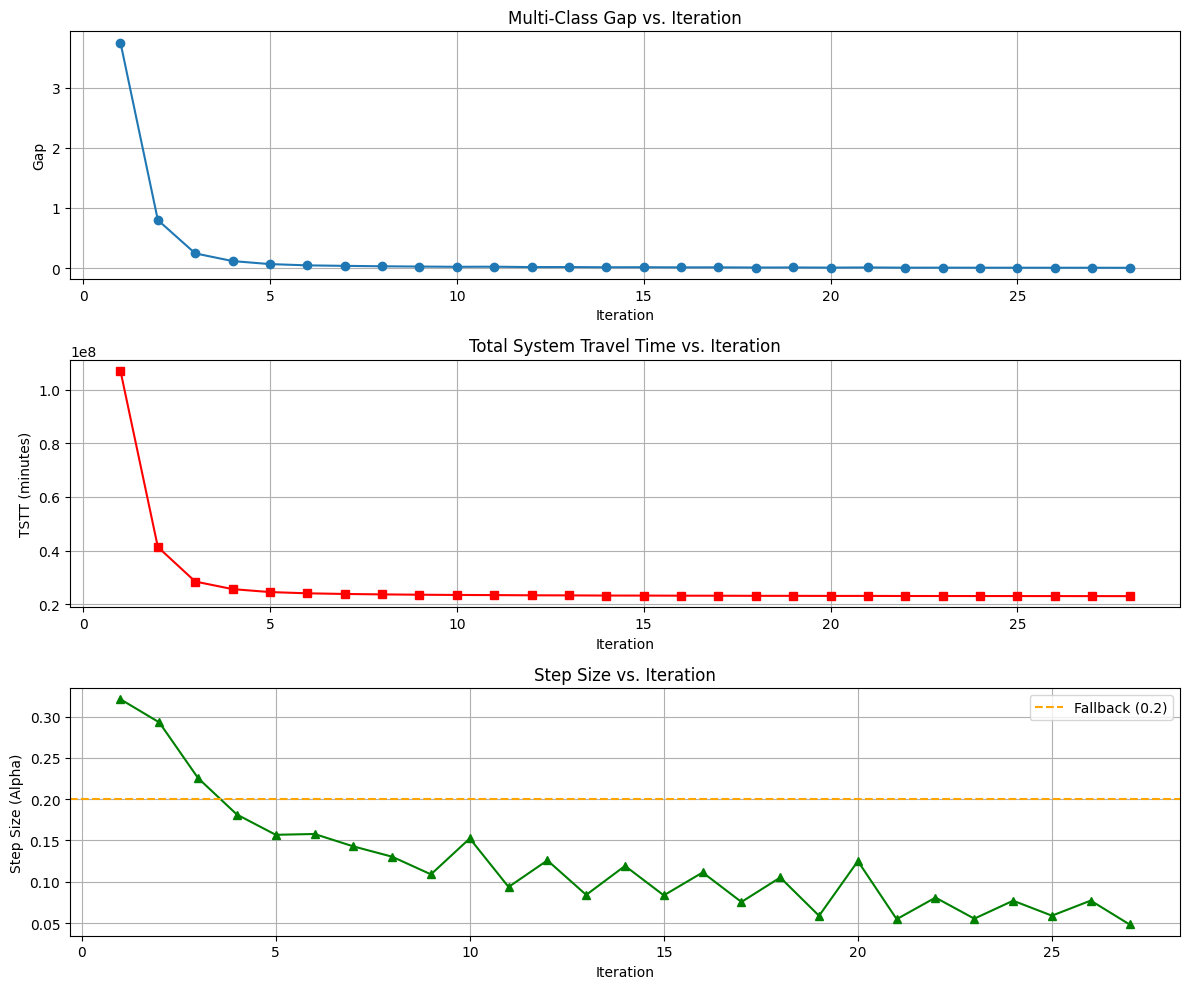

==== Network Health Check ====
完全孤立節點: 0
目前未標定 predecessor 的節點數: 1146
所有流量皆為 0？ False


C:\Users\chiuj\AppData\Local\Temp\ipykernel_19612\1809701336.py:540: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf.to_file(f"{year}_{scenario}_{rush_hour}{case}_UE_results.shp")
C:\Users\chiuj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyogrio\geopandas.py:662: UserWarning: 'crs' was not provided.  The output dataset will not have projection information defined and may not be usable in other systems.
  write(
C:\Users\chiuj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'UE_travelTime' to 'UE_travelT'
  ogr_write(
C:\Users\chiuj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/launder

1045458 OD pairs (含車種)
723 zones
10138 nodes
25629 links
成功讀取 1756 筆轉向限制/懲罰資料
Reading the network data took 6.09 secs
==== 執行初始 AON 載入 ====
==== 開始多車種交通指派迭代 ====
Iteration 1 improved gap: 6.55425, TSTT: 182354350.36 min, SPTT: 24139304.81 min, count reset to 0
迭代 1: fsolve 成功找到步長 α=0.2569
    alpha: 0.2569
    Iteration 1 completed :)
Iteration 2 improved gap: 1.93387, TSTT: 74040459.58 min, SPTT: 25236441.32 min, count reset to 0
迭代 2: fsolve 成功找到步長 α=0.2393
    alpha: 0.2393
    Iteration 2 completed :)
Iteration 3 improved gap: 0.67758, TSTT: 43294650.50 min, SPTT: 25807800.49 min, count reset to 0
迭代 3: fsolve 成功找到步長 α=0.2257
    alpha: 0.2257
    Iteration 3 completed :)
Iteration 4 improved gap: 0.28586, TSTT: 33105853.66 min, SPTT: 25746124.40 min, count reset to 0
迭代 4: fsolve 成功找到步長 α=0.1534
    alpha: 0.1534
    Iteration 4 completed :)
Iteration 5 improved gap: 0.16529, TSTT: 30235505.13 min, SPTT: 25946653.31 min, count reset to 0
迭代 5: fsolve 成功找到步長 α=0.1828
    alpha: 0.1

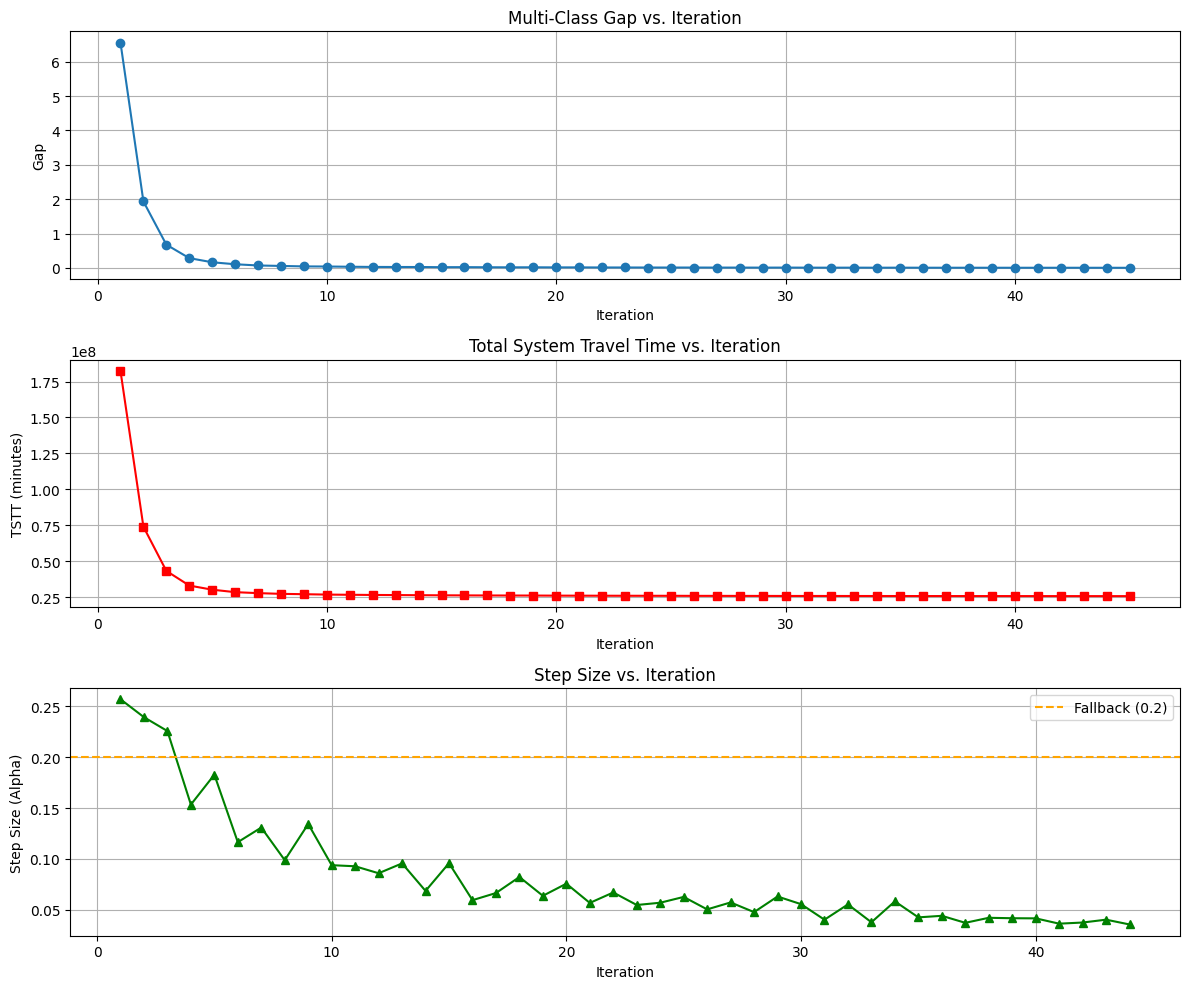

==== Network Health Check ====
完全孤立節點: 0
目前未標定 predecessor 的節點數: 1135
所有流量皆為 0？ False


C:\Users\chiuj\AppData\Local\Temp\ipykernel_19612\1809701336.py:540: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf.to_file(f"{year}_{scenario}_{rush_hour}{case}_UE_results.shp")
C:\Users\chiuj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyogrio\geopandas.py:662: UserWarning: 'crs' was not provided.  The output dataset will not have projection information defined and may not be usable in other systems.
  write(
C:\Users\chiuj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'UE_travelTime' to 'UE_travelT'
  ogr_write(
C:\Users\chiuj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/launder

1045458 OD pairs (含車種)
723 zones
10138 nodes
25628 links
成功讀取 1756 筆轉向限制/懲罰資料
Reading the network data took 6.18 secs
==== 執行初始 AON 載入 ====
==== 開始多車種交通指派迭代 ====
Iteration 1 improved gap: 3.40426, TSTT: 99049722.02 min, SPTT: 22489551.77 min, count reset to 0
迭代 1: fsolve 成功找到步長 α=0.3191
    alpha: 0.3191
    Iteration 1 completed :)
Iteration 2 improved gap: 0.72061, TSTT: 39478011.79 min, SPTT: 22944172.67 min, count reset to 0
迭代 2: fsolve 成功找到步長 α=0.2832
    alpha: 0.2832
    Iteration 2 completed :)
Iteration 3 improved gap: 0.22956, TSTT: 28115855.87 min, SPTT: 22866521.77 min, count reset to 0
迭代 3: fsolve 成功找到步長 α=0.2131
    alpha: 0.2131
    Iteration 3 completed :)
Iteration 4 improved gap: 0.1122, TSTT: 25528352.01 min, SPTT: 22952983.83 min, count reset to 0
迭代 4: fsolve 成功找到步長 α=0.1796
    alpha: 0.1796
    Iteration 4 completed :)
Iteration 5 improved gap: 0.06613, TSTT: 24462051.25 min, SPTT: 22944805.56 min, count reset to 0
迭代 5: fsolve 成功找到步長 α=0.1693
    alpha: 0.169

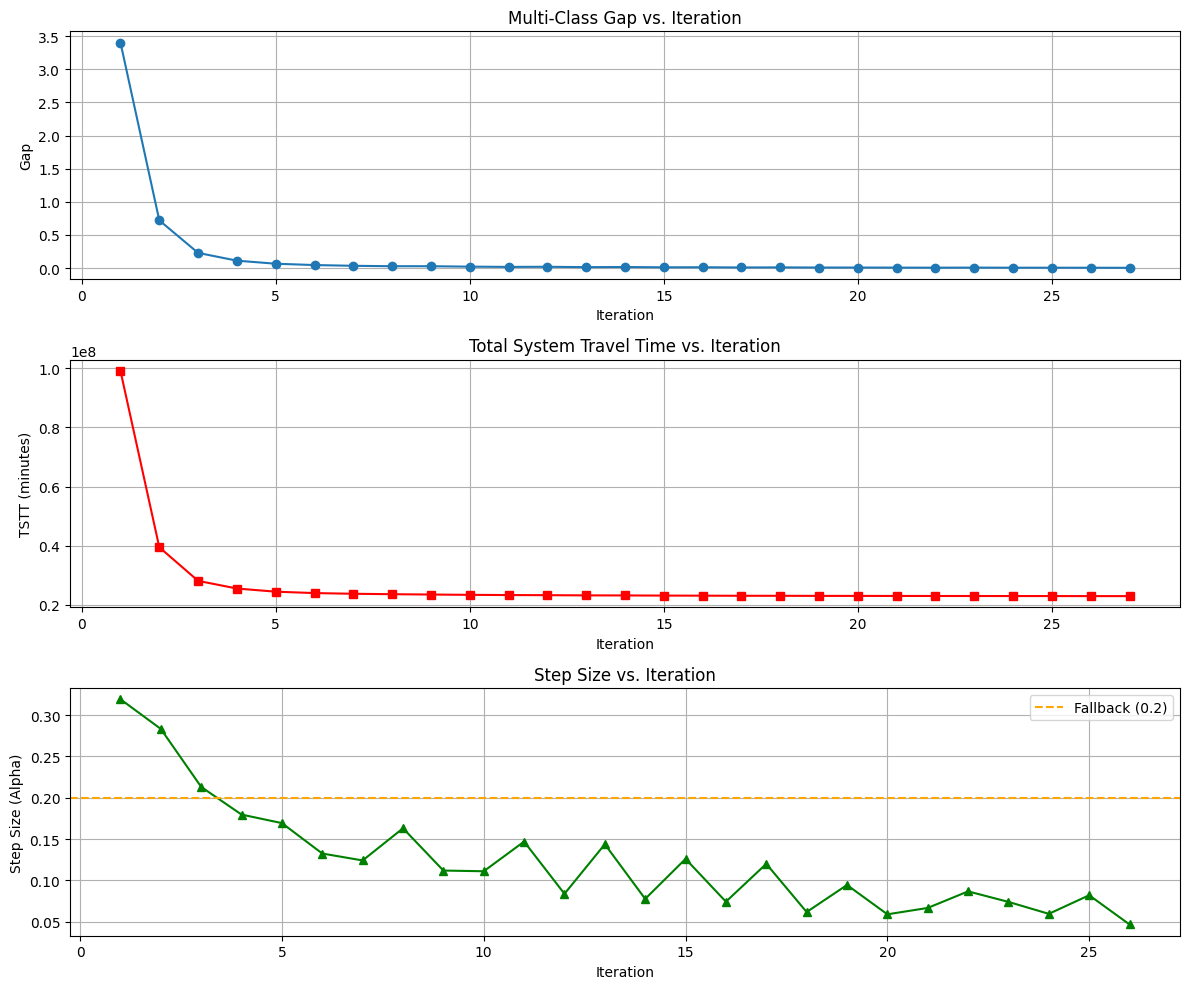

==== Network Health Check ====
完全孤立節點: 0
目前未標定 predecessor 的節點數: 1135
所有流量皆為 0？ False


C:\Users\chiuj\AppData\Local\Temp\ipykernel_19612\1809701336.py:540: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf.to_file(f"{year}_{scenario}_{rush_hour}{case}_UE_results.shp")
C:\Users\chiuj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyogrio\geopandas.py:662: UserWarning: 'crs' was not provided.  The output dataset will not have projection information defined and may not be usable in other systems.
  write(
C:\Users\chiuj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'UE_travelTime' to 'UE_travelT'
  ogr_write(
C:\Users\chiuj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/launder

1045458 OD pairs (含車種)
723 zones
10138 nodes
25629 links
成功讀取 1756 筆轉向限制/懲罰資料
Reading the network data took 5.81 secs
==== 執行初始 AON 載入 ====
==== 開始多車種交通指派迭代 ====
Iteration 1 improved gap: 6.68331, TSTT: 185549048.66 min, SPTT: 24149632.77 min, count reset to 0
迭代 1: fsolve 成功找到步長 α=0.2489
    alpha: 0.2489
    Iteration 1 completed :)
Iteration 2 improved gap: 2.04941, TSTT: 77263332.39 min, SPTT: 25337107.26 min, count reset to 0
迭代 2: fsolve 成功找到步長 α=0.2378
    alpha: 0.2378
    Iteration 2 completed :)
Iteration 3 improved gap: 0.72244, TSTT: 44643993.08 min, SPTT: 25918979.69 min, count reset to 0
迭代 3: fsolve 成功找到步長 α=0.2273
    alpha: 0.2273
    Iteration 3 completed :)
Iteration 4 improved gap: 0.30571, TSTT: 33691067.20 min, SPTT: 25802852.35 min, count reset to 0
迭代 4: fsolve 成功找到步長 α=0.1554
    alpha: 0.1554
    Iteration 4 completed :)
Iteration 5 improved gap: 0.17249, TSTT: 30594252.78 min, SPTT: 26093317.83 min, count reset to 0
迭代 5: fsolve 成功找到步長 α=0.1855
    alpha: 0.1

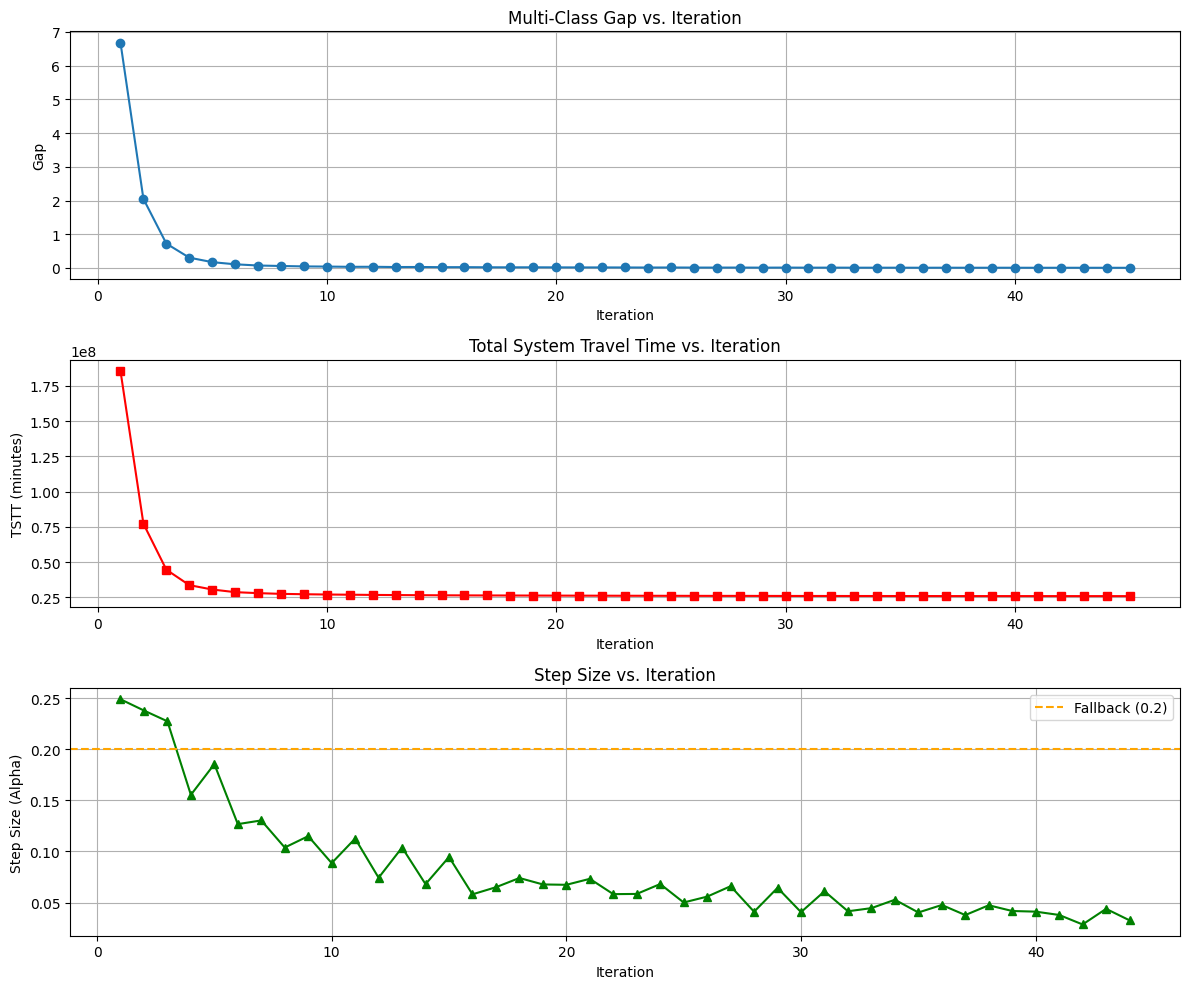

==== Network Health Check ====
完全孤立節點: 0
目前未標定 predecessor 的節點數: 1135
所有流量皆為 0？ False


C:\Users\chiuj\AppData\Local\Temp\ipykernel_19612\1809701336.py:540: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf.to_file(f"{year}_{scenario}_{rush_hour}{case}_UE_results.shp")
C:\Users\chiuj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyogrio\geopandas.py:662: UserWarning: 'crs' was not provided.  The output dataset will not have projection information defined and may not be usable in other systems.
  write(
C:\Users\chiuj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'UE_travelTime' to 'UE_travelT'
  ogr_write(
C:\Users\chiuj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/launder

1045458 OD pairs (含車種)
723 zones
10138 nodes
25628 links
成功讀取 1756 筆轉向限制/懲罰資料
Reading the network data took 5.93 secs
==== 執行初始 AON 載入 ====
==== 開始多車種交通指派迭代 ====
Iteration 1 improved gap: 3.81921, TSTT: 108649868.18 min, SPTT: 22545166.13 min, count reset to 0
迭代 1: fsolve 成功找到步長 α=0.3129
    alpha: 0.3129
    Iteration 1 completed :)
Iteration 2 improved gap: 0.83774, TSTT: 42341530.81 min, SPTT: 23040011.42 min, count reset to 0
迭代 2: fsolve 成功找到步長 α=0.2855
    alpha: 0.2855
    Iteration 2 completed :)
Iteration 3 improved gap: 0.26214, TSTT: 28957023.43 min, SPTT: 22942762.01 min, count reset to 0
迭代 3: fsolve 成功找到步長 α=0.2175
    alpha: 0.2175
    Iteration 3 completed :)
Iteration 4 improved gap: 0.12242, TSTT: 25898911.77 min, SPTT: 23074074.41 min, count reset to 0
迭代 4: fsolve 成功找到步長 α=0.1903
    alpha: 0.1903
    Iteration 4 completed :)
Iteration 5 improved gap: 0.0701, TSTT: 24663119.20 min, SPTT: 23047448.74 min, count reset to 0
迭代 5: fsolve 成功找到步長 α=0.1674
    alpha: 0.16

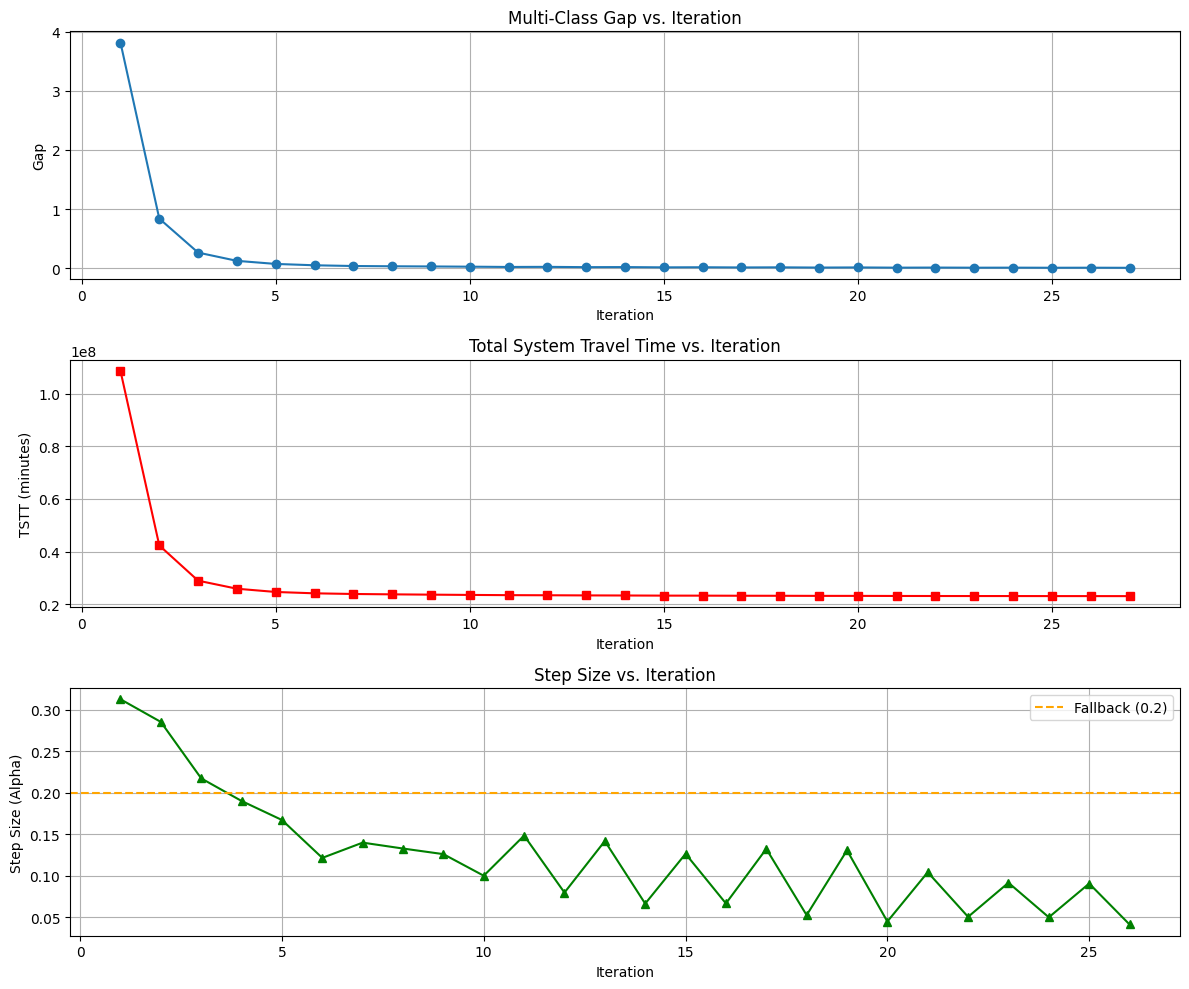

==== Network Health Check ====
完全孤立節點: 0
目前未標定 predecessor 的節點數: 1135
所有流量皆為 0？ False


C:\Users\chiuj\AppData\Local\Temp\ipykernel_19612\1809701336.py:540: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf.to_file(f"{year}_{scenario}_{rush_hour}{case}_UE_results.shp")
C:\Users\chiuj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyogrio\geopandas.py:662: UserWarning: 'crs' was not provided.  The output dataset will not have projection information defined and may not be usable in other systems.
  write(
C:\Users\chiuj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'UE_travelTime' to 'UE_travelT'
  ogr_write(
C:\Users\chiuj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/launder


==== 各情境總體旅行時間比較 ====
現況_晨峰_士林北投三重: TSTT = 25676349.81 分鐘, 總流量 = 18879672.62 輛/小時, 平均步長 = 0.0844
現況_昏峰_士林北投三重: TSTT = 22915721.11 分鐘, 總流量 = 17516655.62 輛/小時, 平均步長 = 0.1286
現況_晨峰_全區域: TSTT = 25787167.86 分鐘, 總流量 = 18949940.72 輛/小時, 平均步長 = 0.0807
現況_昏峰_全區域: TSTT = 23023808.98 分鐘, 總流量 = 17598702.43 輛/小時, 平均步長 = 0.1224
全線拆除_晨峰_士林北投三重: TSTT = 25758903.45 分鐘, 總流量 = 18955380.09 輛/小時, 平均步長 = 0.0815
全線拆除_昏峰_士林北投三重: TSTT = 22959809.70 分鐘, 總流量 = 17578259.86 輛/小時, 平均步長 = 0.1235
全線拆除_晨峰_全區域: TSTT = 25896249.30 分鐘, 總流量 = 19038506.02 輛/小時, 平均步長 = 0.0814
全線拆除_昏峰_全區域: TSTT = 23083694.63 分鐘, 總流量 = 17677951.10 輛/小時, 平均步長 = 0.1237


In [2]:
year = 104
results_summary = {}

for scenario in ['現況', '全線拆除']: # '現況', '全線拆除', '部分拆除'
    for case in ['士林北投三重', '全區域']: # '', '士林北投三重', '全區域'
        for rush_hour in ['晨峰', '昏峰']: # '晨峰', '昏峰'
            tripSet = {}
            zoneSet = {}
            linkSet = {}
            nodeSet = {}
            turn_restrict = {}
            originZones = set()

            readStart = time.time()
            readDemand()
            readNetwork()
            readTurnRestrictions()
            print("Reading the network data took", round(time.time() - readStart, 2), "secs")

            # 執行指派並取得結果
            assignment_result = assignment(
                loading="deterministic",
                algorithm="FW",
                accuracy=0.005,
                maxIter=50,
                allow=5,
                recal=False,
                parallel_loading=True
            )

            # 儲存結果
            results_summary[f"{scenario}_{rush_hour}_{case}"] = assignment_result

            checkNetworkHealth()
            savetoShapefile()

# 印出所有情境的總體旅行時間比較
print("\n==== 各情境總體旅行時間比較 ====")
for scenario_time, result in results_summary.items():
    if result:
        alpha_stats = result.get('alpha_stats', {})
        print(f"{scenario_time}: TSTT = {result['TSTT']:.2f} 分鐘, 總流量 = {result['total_flow_car'] + result['total_flow_scooter']:.2f} 輛/小時, 平均步長 = {alpha_stats.get('mean', 0):.4f}")